# Download ICESat-2 ATL06 data over Hubbard Glacier, downscaled to 20 m

Modified from Slide Rule examples and code developed by [Karina Zikan](https://github.com/KarinaZikan)

Rainey Aberle

In [3]:
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5
import os

## Initialize and configure ICESat-2 API

In [2]:
icesat2.init("slideruleearth.io", verbose=False)

## Load AOI shapefile, reformat to geojson

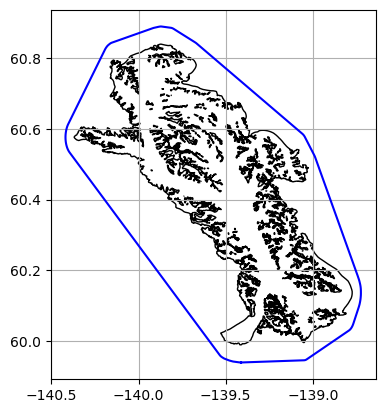

In [20]:
# Define path and filenames for AOI shapefile and geojsons
aoi_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/Hubbard/glacier_boundaries/'
aoi_shp_fn = 'Hubbard_boundaries.shp'
aoi_geojson_fn = 'Hubbard_boundaries.geojson'

# set up figure
fig, ax = plt.subplots(1, 1)

# load shapefile
aoi_shp = gpd.read_file(os.path.join(aoi_path, aoi_shp_fn))
aoi_shp.plot(ax=ax, facecolor='None', edgecolor='k')

# If geojson does not exist in directory, load shapefile, buffer and simplify geometry, save to file as geojson
if not os.path.exists(os.path.join(aoi_path, aoi_geojson_fn)):
    
    # buffer geometry
    aoi_shp['geometry'] = aoi_shp['geometry'][0].buffer(0.05)
    
    # save to aoi_path as geojson
    aoi_shp.to_file(os.path.join(aoi_path, aoi_geojson_fn), driver='GeoJSON')
    print('geojson saved to file: ', os.path.join(aoi_path, aoi_geojson_fn))
        
# read geojson simplified polygon
poly = sliderule.toregion(os.path.join(aoi_path, aoi_geojson_fn))["poly"]

# extract lat and lon coordinates
poly_lon = [x['lon'] for x in poly]
poly_lat = [x['lat'] for x in poly]
    
# plot
ax.plot(poly_lon, poly_lat, '-b')
ax.grid()
plt.show()


## SlideRule Product Processing

In [22]:
# Set parameters
parms = {
    "poly": poly,
    "srt": 0,
    "cnf": icesat2.CNF_SURFACE_HIGH, 
    "ats": 20.0,
    "cnt": 10,
    "len": 20.0,
    "res": 10.0,
    "maxi": 6
}
# Define output CSV file name
csv_fn = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/Hubbard/surface_elevations/ICESat-2/IS2_ATL06_Hubbard.csv'

### Calculate ATL06 elevations

In [23]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
data = icesat2.atl06p(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Received {} elevations".format(data.shape[0]))

# Print data to check results
data

Completed in 53.326 seconds of wall-clock time
Received 30097 elevations


### Plot ATL06 results

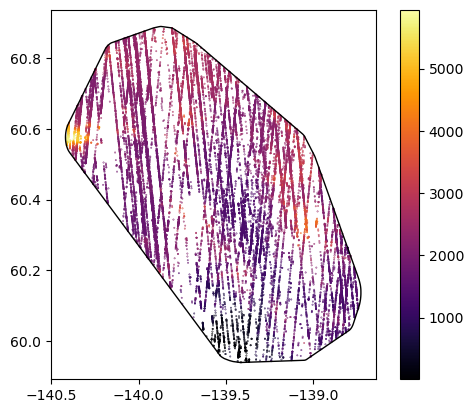

In [39]:
f, ax = plt.subplots(1, 1)
data.plot(ax=ax, column='h_mean', cmap='inferno', s=0.1, legend=True)
ax.plot(poly_lon, poly_lat, linewidth=1, color='k')
plt.show()

### Save ATL06 data to file

In [40]:
data.to_csv(csv_fn)
print('Data saved to file: ', csv_fn)

Data saved to file:  /Users/raineyaberle/Google Drive/My Drive/Research/PhD/Hubbard/surface_elevations/IS2_ATL06_Hubbard.csv
